<a href="https://colab.research.google.com/github/Madhumeera/PRODIGY_DS_04/blob/main/sentimentpatterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# load the data
df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24004 entries, 0 to 24003
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         24004 non-null  int64 
 1   Entity     24004 non-null  object
 2   Sentiment  24004 non-null  object
 3   Content    23784 non-null  object
dtypes: int64(1), object(3)
memory usage: 750.2+ KB


In [ ]:
df.shape

(24004, 4)

In [ ]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

In [ ]:
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      220
dtype: int64

In [ ]:
df.dropna(subset = ['Content'],inplace=True)

In [ ]:
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 835


In [ ]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

In [ ]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

In [ ]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

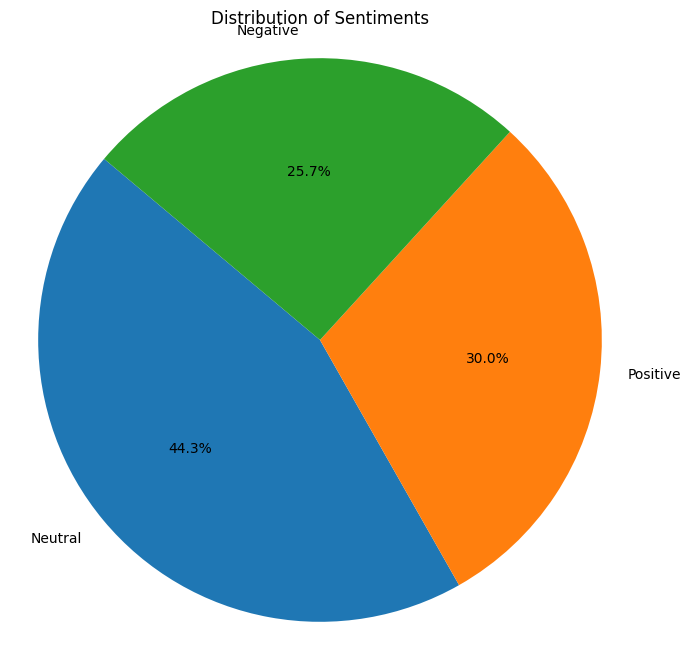

In [ ]:
# Calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Show the pie chart 42.2
plt.show()

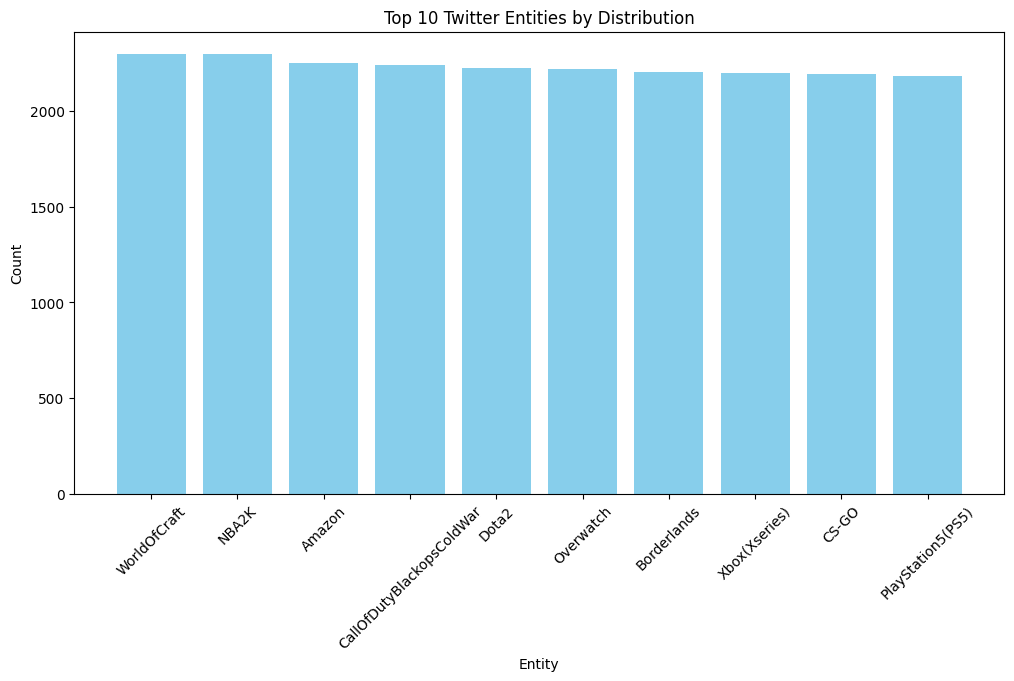

In [ ]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 10 entities
top_10_entities = entity_distribution.head(10)

# Create a bar chart for the top 10 entities
plt.figure(figsize=(12, 6))
plt.bar(top_10_entities.index, top_10_entities.values, color='skyblue')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()


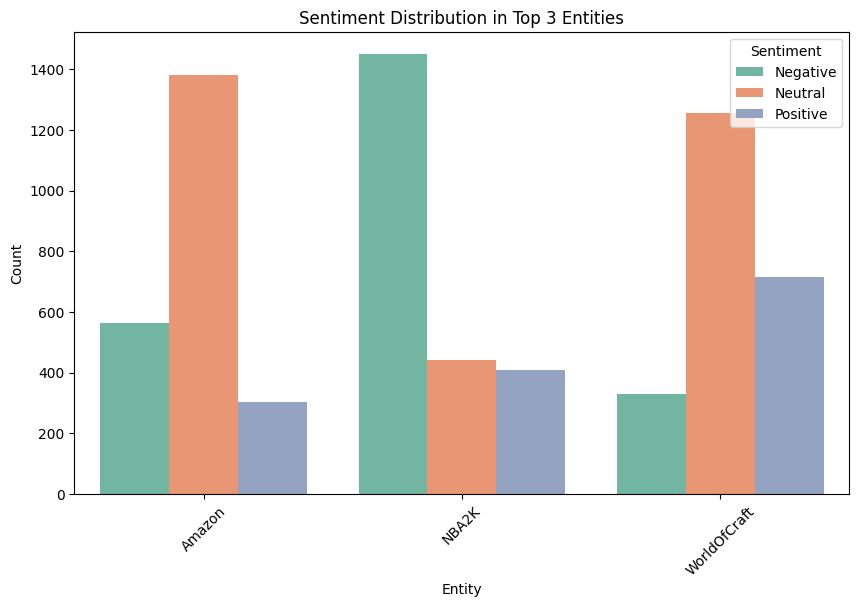

In [ ]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 3 entities
top_3_entities = entity_distribution.head(3).index

# Filter the DataFrame to include only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]

# Create a grouped bar chart for sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the grouped bar chart
plt.show()

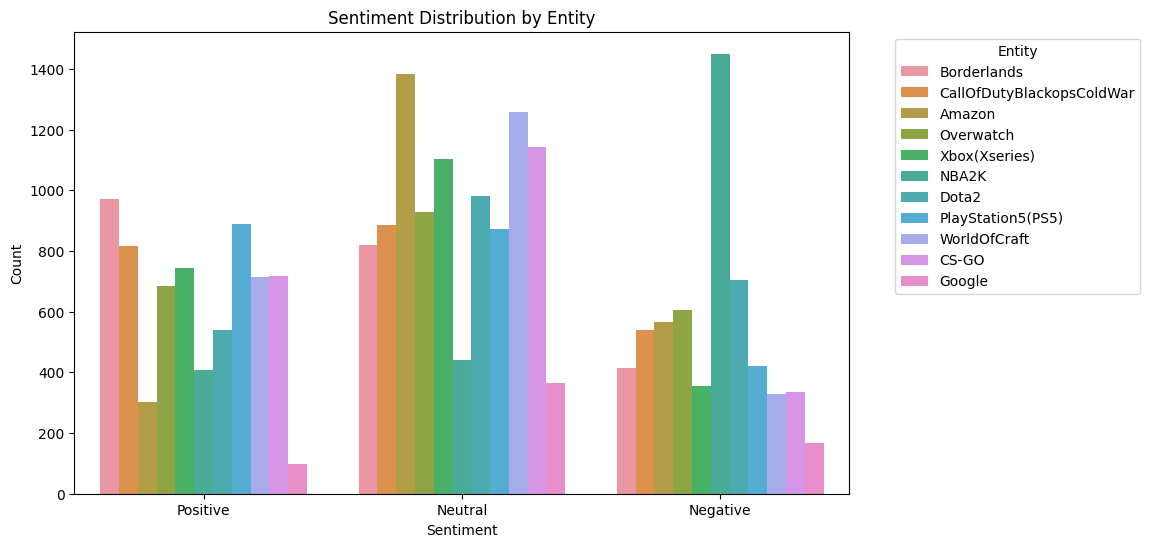

In [ ]:
# Example for sentiment distribution by entity
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# lets Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# loading vader to perform sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


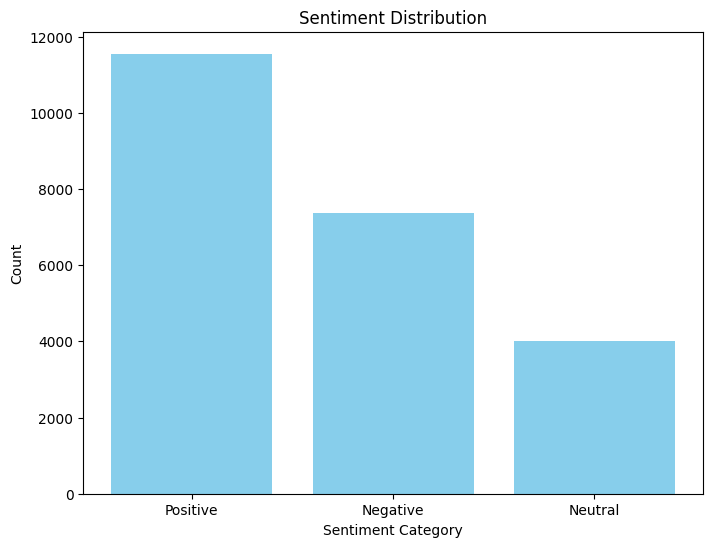

In [ ]:
# lets Calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

# Create a bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# Show the bar chart
plt.show()


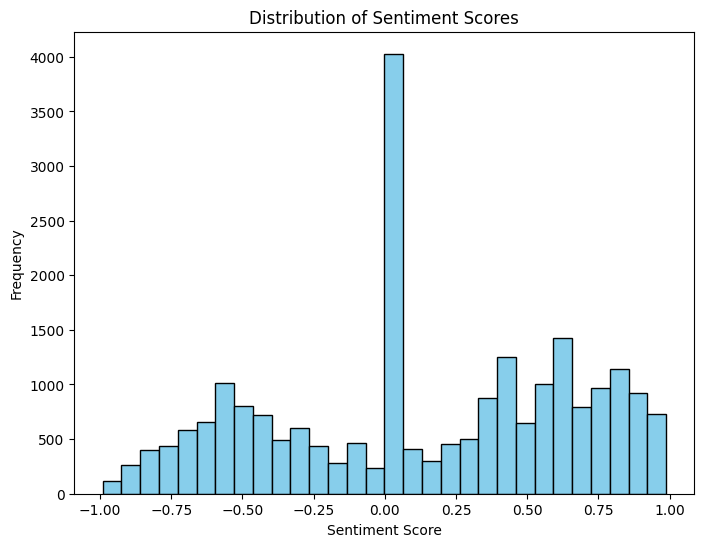

In [ ]:
# Create a histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

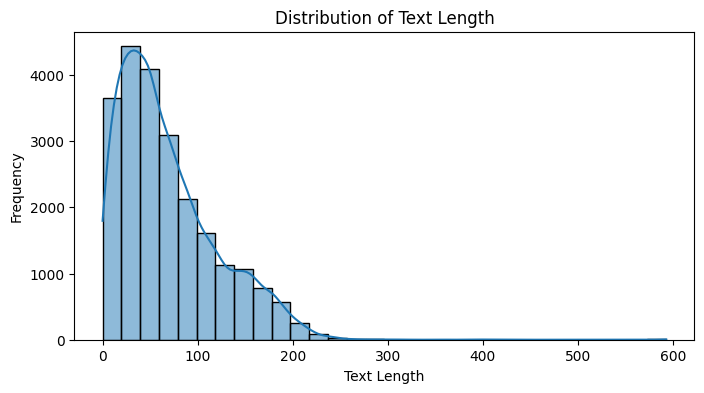

In [ ]:
# for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

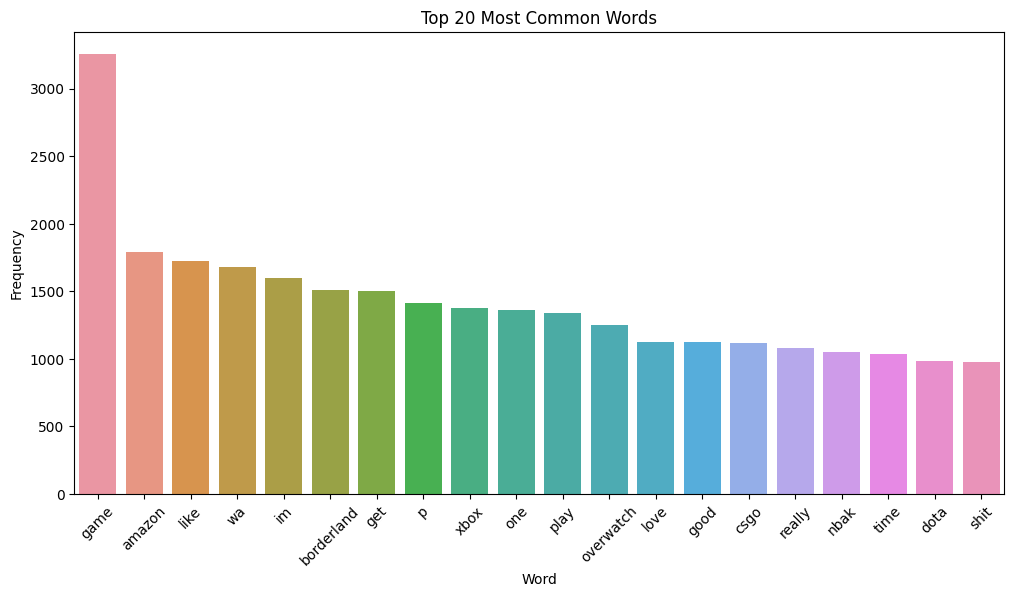

In [ ]:
# word frequency analysis
from collections import Counter

words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

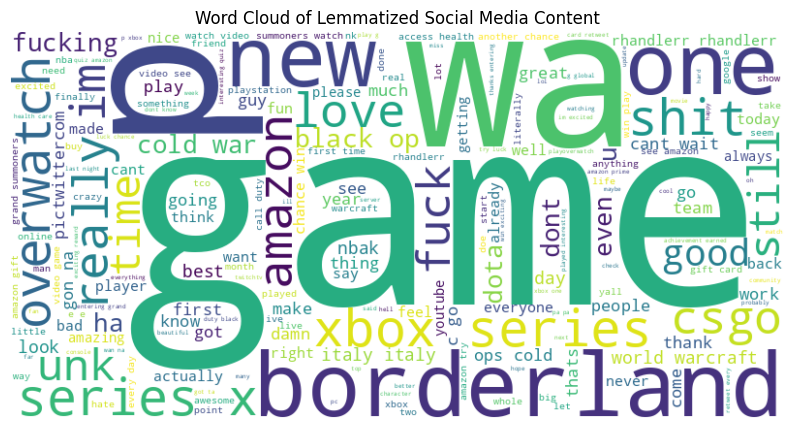

In [ ]:
# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())
# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()

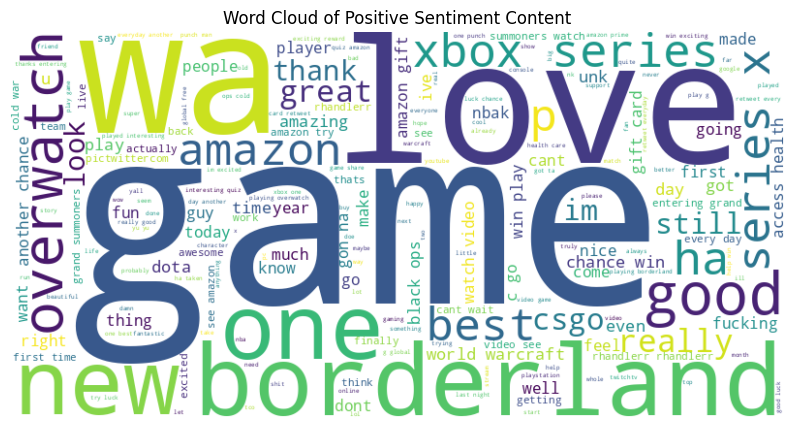

In [ ]:
# Filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()

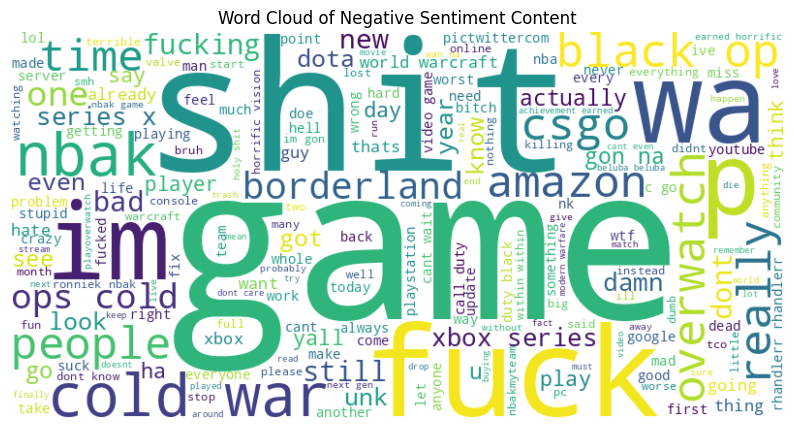

In [ ]:
# lets Filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()

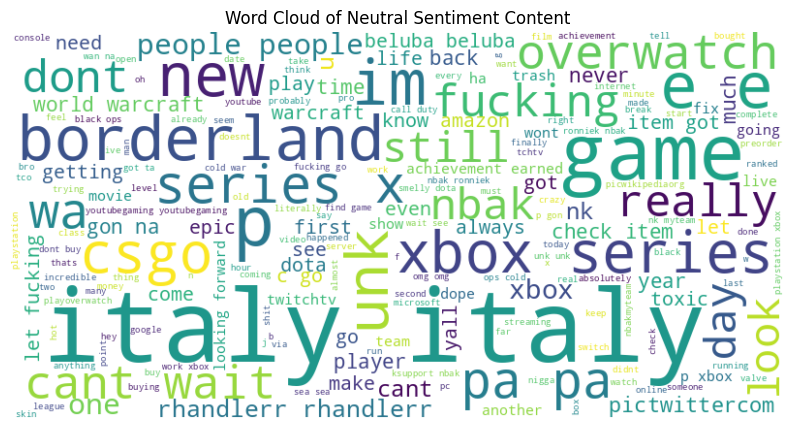

In [ ]:
# lets Filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())

# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()

In [ ]:
# Assign the variables
X = df['Cleaned_Content']  # Features
y = df['Sentiment_Predicted']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# converting the text data to numerical featurees

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Initialize the model
model = LogisticRegression(max_iter=1000, solver='saga')

# Train the model
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8986928104575164
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      1441
     Neutral       0.89      0.80      0.84       787
    Positive       0.91      0.95      0.93      2362

    accuracy                           0.90      4590
   macro avg       0.90      0.87      0.88      4590
weighted avg       0.90      0.90      0.90      4590

